In [7]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipynb.fs.full.project_functions as prf

In [8]:
engine = create_engine('postgresql:///opportunity_youth') # since database is owned by me, no other credentials are needed

### these are the query strings used to retrive the data from postgres

this inlcueds the strings and the items that we queried inorder to retrive the data

In [9]:
str_all = """
SELECT PWGTP, agep, SCHG, SCH, SCHL, ESR
FROM pums_2017
WHERE (puma BETWEEN '11601' AND '11616')
AND (agep BETWEEN 16 AND 24)
"""
### this string will search the opportunity_youth data base for all individuals between the ages of 16 and 24

In [10]:
str_south = """
SELECT PWGTP, agep, SCHG, SCH, SCHL, ESR
FROM pums_2017
WHERE (puma BETWEEN '11610' AND '11615')
AND (agep BETWEEN 16 AND 24)
"""
### this string will search the opportunity_youth data base for all individuals between the ages of 16 and 24

In [11]:
str_yo = """
SELECT PWGTP, agep, SCHG, SCH, SCHL
FROM pums_2017
WHERE (puma BETWEEN '11601' AND '11616')
AND (agep BETWEEN 16 AND 24)
AND (ESR = '3' OR ESR = '6')
AND (SCH = '1')
"""
### this string will search the opportunity_youth data base for all the youth opportunity in king county

In [12]:
str_south_yo = """
SELECT PWGTP, agep, SCHG, SCH, SCHL
FROM pums_2017
WHERE (puma BETWEEN '11610' AND '11615')
AND (agep BETWEEN 16 AND 24)
AND (ESR = '3' OR ESR = '6')
AND (SCH = '1')
"""

In [13]:
str_work_no_dimploma = """
SELECT PWGTP, agep, SCHG, SCH, SCHL, ESR
FROM pums_2017
WHERE (puma BETWEEN '11610' AND '11615')
AND (agep BETWEEN 16 AND 24)
AND (ESR != '3' AND ESR != '6')
AND (SCHL <= '15')
AND (SCH = '1')
"""

In [14]:
df_s = pd.read_sql(sql = str_south, con = engine) #data frame for all people between the ages of 16-24 in South King County
df_s_yo = pd.read_sql(sql = str_south_yo, con = engine) #data frame for all youth opportunity in south King County
df_w_noDiploma = pd.read_sql(sql = str_work_no_dimploma, con = engine) #data frame for all people with no diploma between the ages of 16 and 24 that are working

### functions used for project

In [15]:
def get_average(data, col_name, age1 = 16, age2 = 24):
    try: 
        filtered_data = data[(data.agep >= age1) & (data.agep <= age2)]
        filtered_data['weighted_sum'] = filtered_data[col_name]*filtered_data['pwgtp']
        sum_of_weighted_data = filtered_data['weighted_sum'].sum()
        sum_of_weights = filtered_data['pwgtp'].sum()
        return sum_of_weighted_data/sum_of_weights
    except:
        print("operation could not be completed")


In [16]:
def weight_sum(df):
    weighted_sum = df['pwgtp'].sum()
    return weighted_sum
                      

In [17]:
def trisect_ages(df):
    df_16_18 = df[(df.agep>=16) & (df.agep <= 18)]
    value_16_18 = weight_sum(df_16_18)
    
    df_19_21 = df[(df.agep>=19) & (df.agep <= 21)]
    value_19_21 = weight_sum(df_19_21)
    
    df_22_24 = df[(df.agep>=22) & (df.agep <= 24)]
    value_22_24 = weight_sum(df_22_24)
    
    value_total = weight_sum(df)
    
    value_array = np.array([value_16_18, value_19_21, value_22_24, value_total])
    return value_array

In [18]:
def form_2d_array(df_list):
    new_list = np.zeros(len(df_list)+1)
    df_array = np.array(df_list)
    df_table = np.array([trisect_ages(x_df) for x_df in df_array])
    
    for x in range(len(df_list)+1):
        element = df_table[0][x]-(df_table[1][x]+df_table[2][x])
        new_list[x] = element
    final_table = np.append(df_table, [new_list], axis = 0)
    
    return final_table
    

In [19]:
def create_df(array_entry, columns_entry, index_entry):
    df = pd.DataFrame(array_entry, columns = columns_entry, index = index_entry)
    return df
    

In [20]:
def add_percentages(df):
    for col in df.columns:
        if 'total' in col:
            df["{} percentage".format(col[:5])] = round(df[col]/df.loc['Total Population', col]*100)
    
    

In [21]:
def get_plot_info(df_new, df_original, row):
    labels= ['16-18 percentage', '19-21 percentage', '22-24 percentage', 'total percentage']
    x = [] # values of the first bar graph
    y = [] # values of the second bar graph
    z = np.arange(len(labels)) # label location
    width = .35 # width of the bars
    for col in df_new.columns:
        if ('percentage' in col):
            x.append(df_new.loc[row,col])
    for col in df_original.columns:
        if ('percentage' in col):
            y.append(df_original.loc[row,col])
    return x, y, z, width


### This will create an array using the data

the first_array function takes in a list of dataframes as an arguement and divides the population up into three rows, the first column are people who are 16-18 in age, the second column represents people who are 19-21, the third column represents people who are 22-24 and the fourth column are the toal number of people. The first row represents the total as well, while the second row represents the people who qualify for opportunity youth, the third row are people who don't have a degree but are working, and the last row are the people who don't qualify for opportunity youth.

In [22]:
first_array = form_2d_array([df_s, df_s_yo, df_w_noDiploma])
first_array

array([[30141., 25486., 30256., 85883.],
       [ 1815.,  3902.,  4897., 10614.],
       [  449.,  1400.,  1631.,  3480.],
       [27877., 20184., 23728., 71789.]])

This will create the column names and the row names that will later be used for creating the data

In [23]:
column_names = ['16-18 total', '19-21 total', '22-24 total', '16-24 total']
index_names = ["Total Population", "Opportunity Youth", "Working no Diploma", "Not Opportunity Youth"]

### Creating the Pandas table

In [24]:
df_first_table = pd.DataFrame(first_array, columns = ['16-18 total', '19-21 total', '22-24 total', '16-24 total'], index = ["Total Population", "Opportunity Youth", "Working no Diploma", "Not Opportunity Youth"])
df_first_table

,16-18 total,19-21 total,22-24 total,16-24 total
Total Population,30141.0,25486.0,30256.0,85883.0
Opportunity Youth,1815.0,3902.0,4897.0,10614.0
Working no Diploma,449.0,1400.0,1631.0,3480.0
Not Opportunity Youth,27877.0,20184.0,23728.0,71789.0


### Cleaning Data

though the data doesn't need much cleaning, to get the look of the original table, several new columns were required to represent the percentages of each group

In [25]:
reorganized_list = ['16-18 percentage','16-18 total', '19-21 percentage', '19-21 total', '22-24 percentage', '22-24 total', '16-24 percentage', '16-24 total', ]

In [26]:
df_first_table = df_first_table.reindex(columns = reorganized_list)
df_first_table


,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,NaN,30141.0,NaN,25486.0,NaN,30256.0,NaN,85883.0
Opportunity Youth,NaN,1815.0,NaN,3902.0,NaN,4897.0,NaN,10614.0
Working no Diploma,NaN,449.0,NaN,1400.0,NaN,1631.0,NaN,3480.0
Not Opportunity Youth,NaN,27877.0,NaN,20184.0,NaN,23728.0,NaN,71789.0


In [27]:
add_percentages(df_first_table)


In [28]:
df_first_table

,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,100.0,30141.0,100.0,25486.0,100.0,30256.0,100.0,85883.0
Opportunity Youth,6.0,1815.0,15.0,3902.0,16.0,4897.0,12.0,10614.0
Working no Diploma,1.0,449.0,5.0,1400.0,5.0,1631.0,4.0,3480.0
Not Opportunity Youth,92.0,27877.0,79.0,20184.0,78.0,23728.0,84.0,71789.0


## creating original table from 2016

In [29]:
original_df = np.array([[50053,41651,48031,139735],[2805,7284,8728,18817],[587,2049,2877,5513],[46661,32318,36436,115405]])
original_df

array([[ 50053,  41651,  48031, 139735],
       [  2805,   7284,   8728,  18817],
       [   587,   2049,   2877,   5513],
       [ 46661,  32318,  36436, 115405]])

In [30]:
original_df = create_df(original_df, column_names, index_names)

In [31]:
original_df = original_df.reindex(columns = reorganized_list)
original_df

,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,NaN,50053,NaN,41651,NaN,48031,NaN,139735
Opportunity Youth,NaN,2805,NaN,7284,NaN,8728,NaN,18817
Working no Diploma,NaN,587,NaN,2049,NaN,2877,NaN,5513
Not Opportunity Youth,NaN,46661,NaN,32318,NaN,36436,NaN,115405


In [32]:
add_percentages(original_df)

In [33]:
original_df

,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,100.0,50053,100.0,41651,100.0,48031,100.0,139735
Opportunity Youth,6.0,2805,17.0,7284,18.0,8728,13.0,18817
Working no Diploma,1.0,587,5.0,2049,6.0,2877,4.0,5513
Not Opportunity Youth,93.0,46661,78.0,32318,76.0,36436,83.0,115405


In [34]:
df_first_table

,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,100.0,30141.0,100.0,25486.0,100.0,30256.0,100.0,85883.0
Opportunity Youth,6.0,1815.0,15.0,3902.0,16.0,4897.0,12.0,10614.0
Working no Diploma,1.0,449.0,5.0,1400.0,5.0,1631.0,4.0,3480.0
Not Opportunity Youth,92.0,27877.0,79.0,20184.0,78.0,23728.0,84.0,71789.0


In [35]:
original_df.to_excel('data/processed/original_data.xlsx')

In [36]:
df_first_table.to_excel('data/processed/new_data.xlsx')

In [37]:
df_delta = df_first_table.subtract(original_df, fill_value = 0)
df_delta

,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,0.0,-19912.0,0.0,-16165.0,0.0,-17775.0,0.0,-53852.0
Opportunity Youth,0.0,-990.0,-2.0,-3382.0,-2.0,-3831.0,-1.0,-8203.0
Working no Diploma,0.0,-138.0,0.0,-649.0,-1.0,-1246.0,0.0,-2033.0
Not Opportunity Youth,-1.0,-18784.0,1.0,-12134.0,2.0,-12708.0,1.0,-43616.0


In [38]:
for col in df_delta.columns:
    if 'total' in col:
        del df_delta[col]
df_delta

,16-18 percentage,19-21 percentage,22-24 percentage,16-24 percentage
Total Population,0.0,0.0,0.0,0.0
Opportunity Youth,0.0,-2.0,-2.0,-1.0
Working no Diploma,0.0,0.0,-1.0,0.0
Not Opportunity Youth,-1.0,1.0,2.0,1.0


### Plotting Data

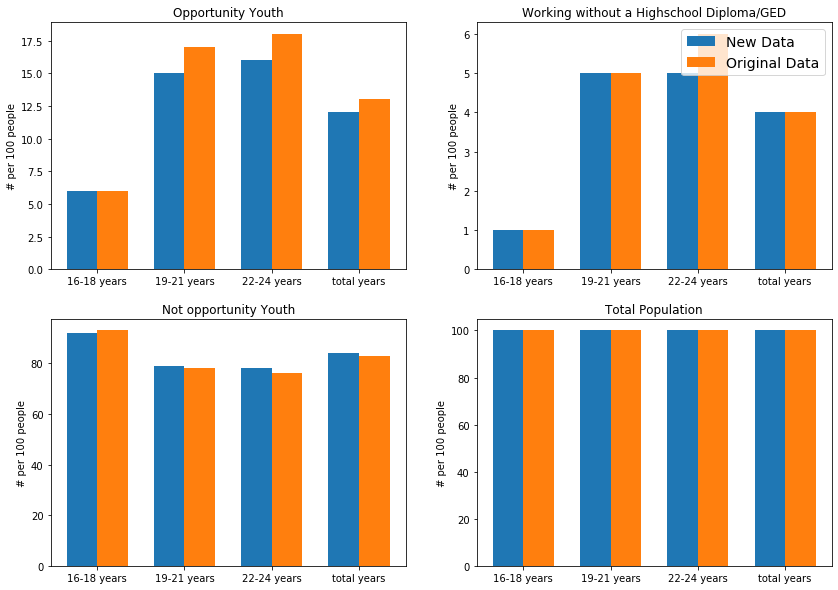

In [39]:
x, y, z, w = get_plot_info(df_first_table, original_df, "Opportunity Youth")
x1, y1, z1, w1 = get_plot_info(df_first_table, original_df, "Working no Diploma")
x2, y2, z2, w2 = get_plot_info(df_first_table, original_df, "Not Opportunity Youth")
x3, y3, z3, w3 = get_plot_info(df_first_table, original_df, "Total Population")

labels = ['16-18 years', '19-21 years', '22-24 years', 'total years']

fig, ax = plt.subplots(2,2, figsize = (14,10))

rect1a = ax[0][0].bar(z - w/2, x,  w, label='New Data')
rect1b = ax[0][0].bar(z + w/2, y,  w, label='Original Data')

rect2a = ax[0][1].bar(z1 - w1/2, x1,  w1, label='New Data')
rect2b = ax[0][1].bar(z1 + w1/2, y1,  w1, label='Original Data')

rect3a = ax[1][0].bar(z2 - w2/2, x2,  w2, label='New Data')
rect3b = ax[1][0].bar(z2 + w2/2, y2,  w2, label='Original Data')

rect4a = ax[1][1].bar(z3 - w3/2, x3,  w3, label='New Data')
rect4b = ax[1][1].bar(z3 + w3/2, y3,  w3, label='Original Data')


# ax.set_ylabel('Scores')
ax[0][0].title.set_text('Opportunity Youth')
ax[0][1].title.set_text('Working without a Highschool Diploma/GED')
ax[1][0].title.set_text('Not opportunity Youth')
ax[1][1].title.set_text('Total Population')


for x in range(2):
    for y in range (2):
        ax[x][y].set_xticks(z)
        ax[x][y].set_xticklabels(labels)
        ax[x][y].set_ylabel('# per 100 people')
        
# ax[0][0].set_xticks(z)
# ax[0][1].set_xticks(z)
# ax[1][0].set_xticks(z)
# ax[0][0].set_xticklabels(labels)
# ax[0][1].set_xticklabels(labels)
# ax[1][0].set_xticklabels(labels)

ax[0][1].legend(prop= {'size':14})


# Garbage work for testing out additional stuff not relevant for table


In [40]:
df_array = np.array([df_s, df_yo_south, df_w_noDiploma])
df_table = np.array([trisect_ages(df) for df in df_array])

print(df_table)

new_list = np.array([0, 0, 0, 0])
for x in range(4):
    element = df_table[0][x]-(df_table[1][x]+df_table[2][x])
    new_list[x] = element
print(new_list)
np.append(df_table, [new_list], axis = 0)

NameError: name 'df_yo_south' is not defined

In [ ]:
filtered_data = df_all[(df_all.agep >= 16) & (df_all.agep <= 18)]

In [ ]:
filtered_data.head(df_first_table, fill_value )

In [ ]:
filtered_data['weighted_sum'] = filtered_data['agep']*filtered_data['pwgtp']
weighted_sum = filtered_data['weighted_sum'].sum()
sum_weights = filtered_data['pwgtp'].sum()
average_weight = weighted_sum/sum_weights
print(average_weight)



In [ ]:
df_16_18 = df_all[(df_all['agep']>= 16.0) & (df_all['agep']<= 18.0)]
total_number_16_18 = df_16_18['pwgtp'].sum()
total_number_16_18

In [ ]:
df_yo= pd.read_sql(sql = search_string_yo, con = engine)

In [ ]:
df_all.head()
df_all.shape